<a href="https://colab.research.google.com/github/mariabandeira/AdministracaoPublica/blob/main/CadUnico/RandomForest/TrainningPB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score

In [22]:
data = pd.read_csv('https://raw.githubusercontent.com/mariabandeira/AdministracaoPublica/refs/heads/main/CadUnico/BasesPB/cadunico_pb_cleaned.csv', sep=',', encoding='utf-8')

In [23]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [24]:
feature_names = data.columns.tolist()

### Treinando o modelo RF

In [25]:
# analisando a distribuição da variável alvo (marc_pbf)
target_distribution = data['marc_pbf'].value_counts(normalize=True) * 100

print(round(target_distribution))

marc_pbf
1    61.0
0    39.0
Name: proportion, dtype: float64


In [26]:
# separar X (features) e y (target)
X = data.drop('marc_pbf', axis=1)
y = data['marc_pbf']

# treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# aplicando SMOTE para balancear o conjunto de treino
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(y_train_balanced.value_counts())

marc_pbf
1    77593
0    77593
Name: count, dtype: int64


In [27]:
# criar e treinar o modelo
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced')
rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [28]:
# Fazer previsões
y_pred = rf_model.predict(X_test)

# Avaliar métricas
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# Métrica ROC-AUC
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82     21189
           1       0.86      0.94      0.90     33467

    accuracy                           0.87     54656
   macro avg       0.88      0.85      0.86     54656
weighted avg       0.87      0.87      0.87     54656

Matriz de Confusão:
[[15857  5332]
 [ 1849 31618]]
AUC-ROC: 0.9058338564127634


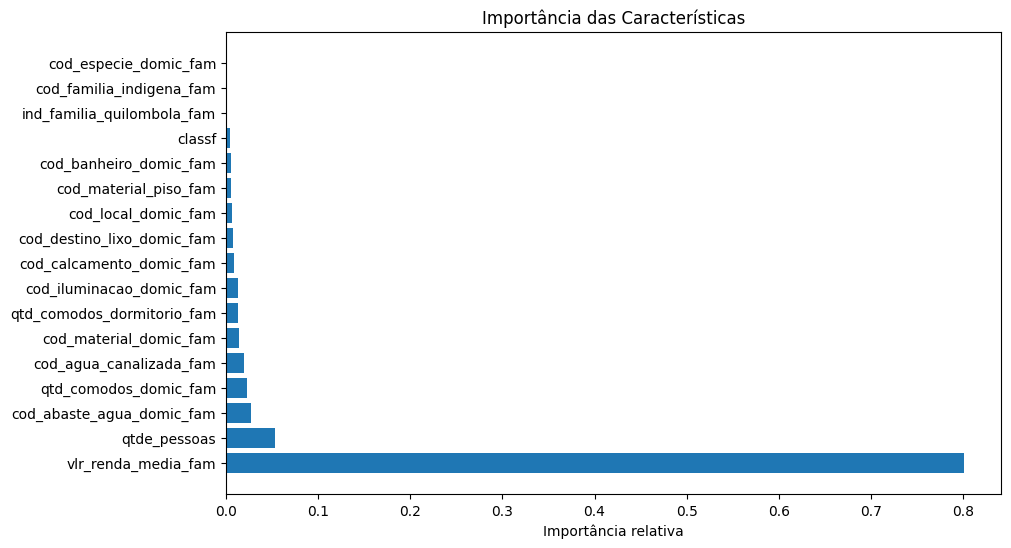

In [29]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Obtendo a importância das características
importances = rf_model.feature_importances_

# Ordenando as características de acordo com a importância
indices = np.argsort(importances)[::-1]

# Visualizando a importância das características
plt.figure(figsize=(10, 6))
plt.title("Importância das Características")
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), np.array(feature_names)[indices])  # Se tiver os nomes das características
plt.xlabel("Importância relativa")
plt.show()

### Selecionando features com SelectKBests

In [30]:
selector = SelectKBest(score_func=f_classif, k=5)
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test)

selected_columns = X_train.columns[selector.get_support()]
print("Características selecionadas:", selected_columns)

Características selecionadas: Index(['vlr_renda_media_fam', 'qtd_comodos_domic_fam',
       'cod_agua_canalizada_fam', 'cod_abaste_agua_domic_fam', 'qtde_pessoas'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 3 14] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [31]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_selected, y_train_balanced)

RandomForestClassifier(random_state=42)

In [32]:
# Fazer previsões
y_pred = model.predict(X_test_selected)

# Avaliar métricas
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# Métrica ROC-AUC
y_pred_prob = model.predict_proba(X_test_selected)[:, 1]
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80     21189
           1       0.85      0.92      0.89     33467

    accuracy                           0.85     54656
   macro avg       0.86      0.83      0.84     54656
weighted avg       0.85      0.85      0.85     54656

Matriz de Confusão:
[[15762  5427]
 [ 2571 30896]]
AUC-ROC: 0.8860751686036319
